In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd drive/MyDrive/Colab\ Notebooks
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display


In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_Weather_EIA.csv")

# Convert YearMonth to datetime
df['YearMonth'] = pd.to_datetime(df['YearMonth'])
df = df.sort_values('YearMonth').reset_index(drop=True)

# Impute Missing Values (Linear)
# Interpolate pollution variables by time
df[['CO_ppm', 'NO2_ppb', 'PM25_ugm3']] = df[['CO_ppm', 'NO2_ppb', 'PM25_ugm3']].interpolate(method='linear')


# Feature Selection
# Drop redundant or uninformative columns
drop_cols = ['Percent Electric Vehicles', 'TMAX', 'TMIN']
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Rename
df = df.rename(columns={
    'Electric Vehicle (EV) Total': 'EV_Total'
})

# Scaling (Standardization)
# Define feature columns (X) and target (y)
feature_cols = ['EV_Total', 'AWND', 'PRCP', 'TAVG', 'Renewable_Share', 'Coal_Share']
target_col = 'NO2_ppb'

# Keep non-feature columns
meta_cols = ['YearMonth']

# Scale features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])

# Save scaled version
df_scaled.to_csv("Cleaned_Monthly_Dataset_Scaled.csv", index=False)

# save unscaled version
df.to_csv("Cleaned_Monthly_Dataset_Unscaled.csv", index=False)


In [4]:
# Read VMT.xlsx
vmt_df = pd.read_excel('/content/drive/MyDrive/bdanp a1/VMT.xlsx')

# Standardize column names
vmt_df.columns = vmt_df.columns.str.strip()

# Convert 'Date'
vmt_df['Date'] = pd.to_datetime(vmt_df['Date'], format='%m/%Y', errors='coerce')
vmt_df['YearMonth'] = vmt_df['Date'].dt.strftime('%Y-%m')

# Rename VMT column
vmt_df = vmt_df.rename(columns={'Vehicle-miles M(Millions)': 'VMT'})

# Save as CSV
vmt_df[['YearMonth', 'VMT']].to_csv('/content/drive/MyDrive/bdanp a1/VMT.csv', index=False)

# Read the main dataset
main_df = pd.read_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_Weather_EIA.csv')
main_df.columns = main_df.columns.str.strip()
main_df['YearMonth'] = main_df['YearMonth'].astype(str).str.strip()

# Merge two datasets
merged_df = pd.merge(main_df, vmt_df[['YearMonth', 'VMT']], on='YearMonth', how='left')

# Save to a new CSV
merged_df.to_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_VMT.csv', index=False)

# Check
print(merged_df[['YearMonth', 'VMT']].head())


  YearMonth     VMT
0   2017-01  4113.0
1   2017-02  4261.0
2   2017-03  5060.0
3   2017-04  5070.0
4   2017-05  5710.0


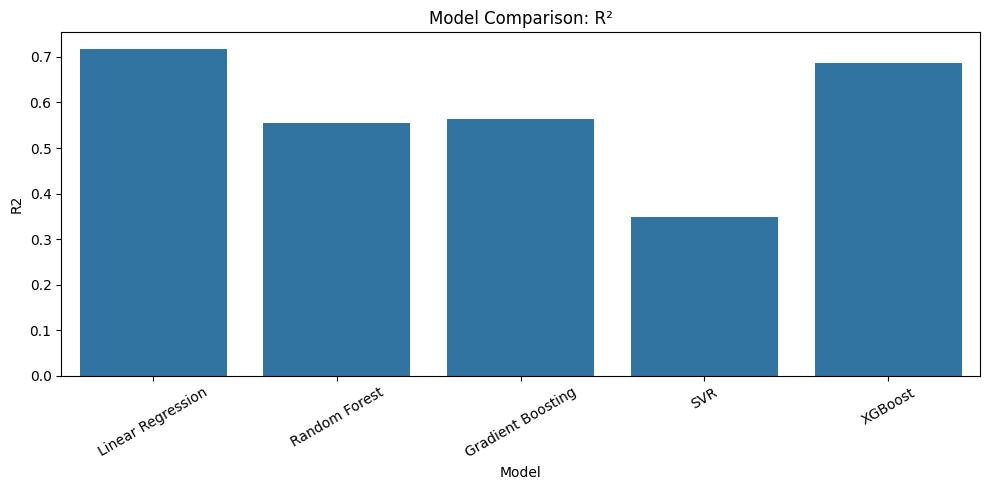

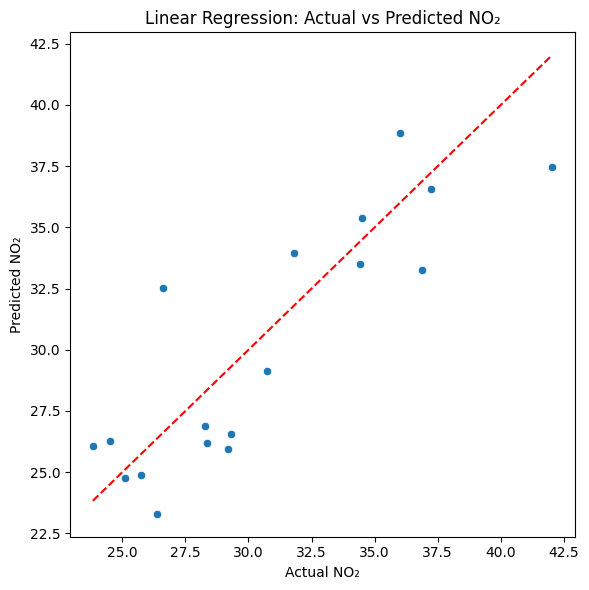

,Model,R2,MSE,RMSE,MAE,MAPE(%)
0,Linear Regression,0.718171,7.191829,2.681759,2.278230,23.465614
1,Random Forest,0.556074,11.328296,3.365753,2.681984,19.386981
2,Gradient Boosting,0.564588,11.111037,3.333322,2.797772,20.463626
3,SVR,0.348446,16.626651,4.077579,3.105882,20.001648
4,XGBoost,0.686325,8.004502,2.829223,2.303246,19.087619


In [5]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/bdanp a1/Final_Monthly_Dataset_With_VMT.csv')

# Drop rows (missing values)
df = df.dropna(subset=['NO2_ppb', 'VMT'])

# Fill with  medians
df = df.fillna(df.median(numeric_only=True))

# Define features and target
X = df.drop(columns=['NO2_ppb', 'YearMonth'])
y = df['NO2_ppb']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2  = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append({'Model': name, 'R2': r2, 'MSE': mse})

results_df = pd.DataFrame(results)

# Bar plot of R² scores
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2')
plt.title("Model Comparison: R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Identify the highest R²
best_model_name = results_df.loc[results_df['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

# Fit the best model and make predictions
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Scatter plot
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual NO₂")
plt.ylabel("Predicted NO₂")
plt.title(f"{best_model_name}: Actual vs Predicted NO₂")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()


# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = pd.Series(y_true), pd.Series(y_pred)
    epsilon = 1e-10  # prevent division by zero
    ape = np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)) * 100
    return ape.mean()

# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2   = r2_score(y_test, y_pred)
    mse  = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    results.append({
        'Model': name,
        'R2': r2,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE(%)': mape
    })

# Display
results_df = pd.DataFrame(results)
display(results_df)


Best Parameters for Random Forest: {'max_depth': 10, 'n_estimators': 200}
Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


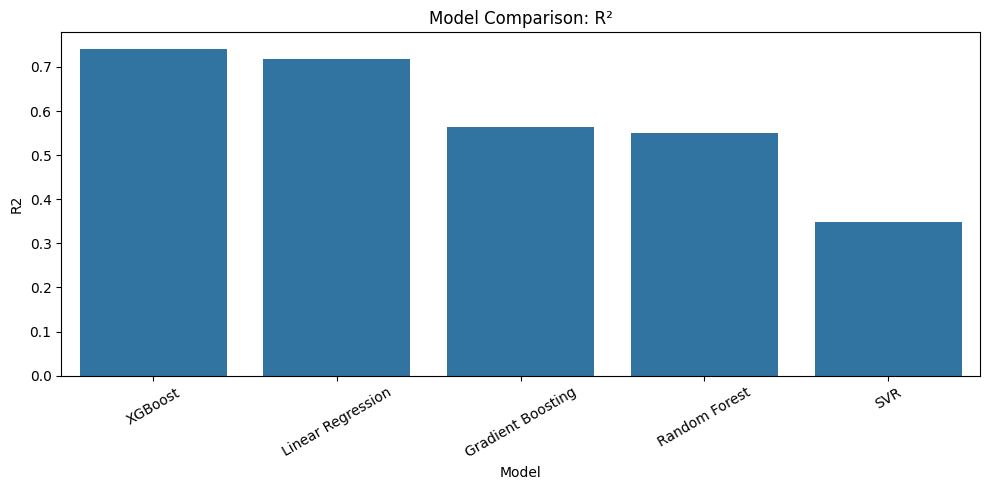

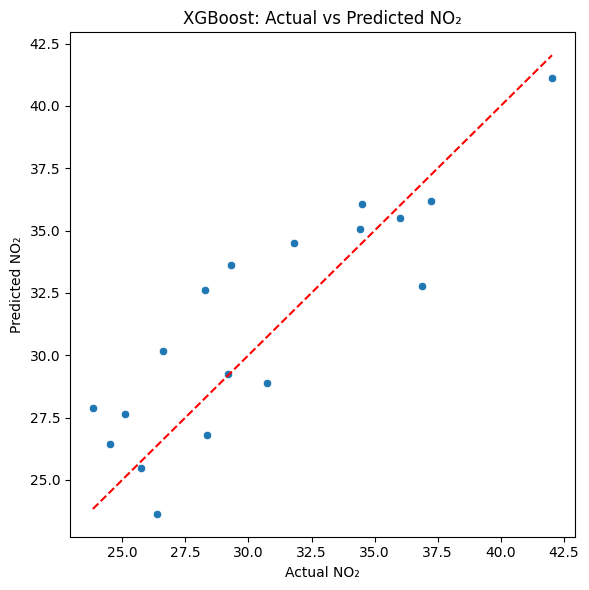

,Model,R2,MSE,RMSE,MAE,MAPE(%)
4,XGBoost,0.741302,6.601568,2.569352,2.144227,7.421709
0,Linear Regression,0.718171,7.191829,2.681759,2.278230,7.544279
1,Gradient Boosting,0.564588,11.111037,3.333322,2.797772,9.262453
3,Random Forest,0.551180,11.453194,3.384257,2.655121,8.726639
2,SVR,0.348446,16.626651,4.077579,3.105882,9.645071


In [7]:
# Define models with GridSearchCV
models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

# Grid search for Random Forest
rf_params = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20],
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, scoring='r2', n_jobs=-1)
rf_grid.fit(X_train, y_train)
models["Random Forest"] = rf_grid.best_estimator_

# Print best hyperparameters
print("Best Parameters for Random Forest:", rf_grid.best_params_)

# Grid search for XGBoost
xgb_params = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.05, 0.1],
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_params, cv=3, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train, y_train)
models["XGBoost"] = xgb_grid.best_estimator_

# Print best hyperparameters for XGBoost
print("Best Parameters for XGBoost:", xgb_grid.best_params_)

# Train and evaluate all models
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    results.append({
        "Model": name,
        "R2": r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE(%)": mape
    })

# Sort by R² score
results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)

# Plot R² scores
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='R2')
plt.title("Model Comparison: R²")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Identify the best model
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

# Plot
y_pred = best_model.predict(X_test)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual NO₂")
plt.ylabel("Predicted NO₂")
plt.title(f"{best_model_name}: Actual vs Predicted NO₂")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.tight_layout()
plt.show()

# Display evaluation
display(results_df)


In [8]:
# Feature
features_all = df.drop(columns=['NO2_ppb', 'YearMonth'])
features_no_vmt = features_all.drop(columns=['VMT'])# Excluding VMT

target = df['NO2_ppb']

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42, verbosity=0),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR(),
}

# Store results
results = []

for name, model in models.items():
    # With VMT
    X_train1, X_test1, y_train1, y_test1 = train_test_split(features_all, target, test_size=0.2, random_state=42)
    model.fit(X_train1, y_train1)
    r2_with_vmt = r2_score(y_test1, model.predict(X_test1))

    # Without VMT
    X_train2, X_test2, y_train2, y_test2 = train_test_split(features_no_vmt, target, test_size=0.2, random_state=42)
    model.fit(X_train2, y_train2)
    r2_without_vmt = r2_score(y_test2, model.predict(X_test2))

    results.append({
        "Model": name,
        "R² with VMT": round(r2_with_vmt, 3),
        "R² without VMT": round(r2_without_vmt, 3),
        "Difference": round(r2_with_vmt - r2_without_vmt, 3)
    })

# Output
results_df = pd.DataFrame(results)
print(results_df)


               Model  R² with VMT  R² without VMT  Difference
0  Linear Regression        0.718           0.686       0.032
1      Random Forest        0.551           0.544       0.007
2            XGBoost        0.741           0.739       0.002
3  Gradient Boosting        0.565           0.599      -0.034
4                SVR        0.348           0.348       0.000


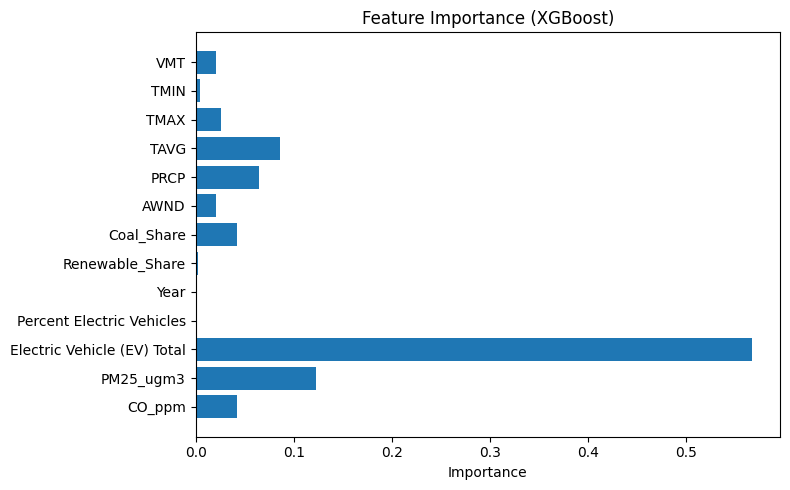

In [9]:
# Fit XGBoost model
model = XGBRegressor().fit(X, y)

# Get feature importances
importances = model.feature_importances_
feat_names = X.columns

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_names, importances)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
